Мобильная игра зарабатывает на показе рекламы. Есть несколько форматов:
int – полноэкранная реклама; banner – горизонтальный баннер, висит внизу
экрана пока юзер играет; rv – видео, которое юзер смотрит по желанию и за
просмотр получает монетки или др. ресурсы. Информация о каждом показе
отправляется в аналитику и содержит доход от показа, формат показанной
рекламы, рекламную сеть от которой был показ и др.
eCPM – доход за 1000 показов рекламы.

# Провести исследование показов рекламы с целью понять на сколько отличается eCPM в зависимости от географии (города) юзера, версии ОС и других параметров. Интересны любые инсайты и находки по eCPM-ам.

1. Для каждого формата рекламы:

a. построить распределение средних eCPM-ов юзеров

b. построить распределение eCPM-ов по городам, версиям ОС

c. построить распределение доходов по городам, версиям ОС

2. Учесть статистическую значимость (отобразить, отфильтровать незначимое
или хотя бы прокомментировать). Объяснить решение.

3. Описать наблюдения и вывод по исследованию.

#### Откорректированное задание:

1. Для каждого формата рекламы:

a. построить распределение средних eCPM-ов юзеров

b. отобразить средние eCPM-ы по городам, версиям ОС

c. отобразить суммарные доходы по городам, версиям ОС

2. Учесть статистическую значимость для п.1b (отобразить, отфильтровать
незначимое или хотя бы прокомментировать). Объяснить решение.

3. Описать наблюдения и вывод по исследованию.

#### Дополнительные (по желанию)
Исследовать:

– Какой процент доходов содержит информацию о городе юзера

– Зависит ли eCPM от времени дня

In [1]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
from natsort import natsort_keygen

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy import stats 
import matplotlib.pyplot as plt
import pylab

In [2]:
df = pd.read_csv('us events ad_revenue filtered 03.02-07.02.csv')

In [3]:
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


Столбец profile_id – id юзера

Столбец event_json содержит данные о событии показа рекламы:

ad_type – формат рекламы (int, banner или rv)

placement – когда/где был показ рекламы в игре

view_index – номер показа конкретного формата рекламы для юзера (не
поддерживается для баннеров)

revenue – доход от конкретного показа рекламы (eCPM = revenue * 1000)

ads_ltv – накапливающийся доход от рекламы, равен сумме всех revenue
юзера

network_name – рекламная сеть, от которой был показ

In [4]:
df.shape

(860079, 16)

In [5]:
df.info()
# пустые значения есть в столбцах id профиля
# название оператора, город

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   profile_id               860065 non-null  object
 1   os_version               860079 non-null  object
 2   device_manufacturer      860079 non-null  object
 3   device_model             860079 non-null  object
 4   device_type              860079 non-null  object
 5   device_locale            860079 non-null  object
 6   event_name               860079 non-null  object
 7   event_json               860079 non-null  object
 8   event_datetime           860079 non-null  object
 9   event_timestamp          860079 non-null  int64 
 10  event_receive_datetime   860079 non-null  object
 11  event_receive_timestamp  860079 non-null  int64 
 12  connection_type          860079 non-null  object
 13  operator_name            841200 non-null  object
 14  country_iso_code    

In [6]:
df.duplicated().sum()
#  дубликатов нет

0

Преобразуем данные столбца event_json в отдельные столбцы

In [7]:
df.event_json = df.event_json.apply(lambda x: json.loads(x))

In [8]:
df_json = pd.json_normalize(df['event_json'])

In [9]:
df = pd.concat([df, df_json], axis=1)

In [10]:
df.shape

(860079, 33)

In [11]:
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,...,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-04 20:02:28,1643994148,...,0.487877,0.511508,0.511508,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ3XirfD5vUCFYPnKAUdG3MOYQ
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-04 20:02:45,1643994165,...,0.488387,0.511389,0.511389,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNa-lL_D5vUCFZrpKAUdU2QBDQ
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-05 17:53:05,1644072785,...,0.678479,0.928597,0.928597,0.002386,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,pandora-58
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{'ad_type': 'int', 'placement': 'next_level', ...",2022-02-06 17:09:01,1644156541,...,0.013894,13.782633,13.893784,0.013894,USD,US,AppLovin,3ab7705b07ebb75f,inter_regular,13045364
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-06 17:15:38,1644156938,...,0.060571,1.660282,1.660282,0.006828,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/6197324251,CMTi5e-h6_UCFUdVwQodt9EIMw


In [13]:
df['eCPM'] = df['revenue'] * 1000


# Для каждого формата рекламы построить распределение средних eCPM-ов юзеров

ad_type – формат рекламы (int, banner или rv)

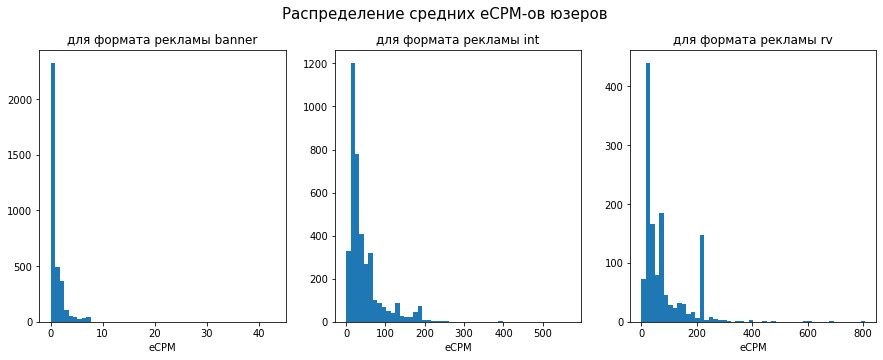

In [14]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.hist(df.groupby(['ad_type', 'profile_id'], as_index=False).agg({'eCPM': 'mean'}) \
  .query('ad_type == "banner"').eCPM, bins = 50)
plt.xlabel('eCPM')
plt.title("для формата рекламы banner")

plt.subplot(1, 3, 2)
plt.hist(df.groupby(['ad_type', 'profile_id'], as_index=False).agg({'eCPM': 'mean'}) \
  .query('ad_type == "int"').eCPM, bins = 50)
plt.xlabel('eCPM')
plt.title("для формата рекламы int")

plt.subplot(1, 3, 3)
plt.hist(df.groupby(['ad_type', 'profile_id'], as_index=False).agg({'eCPM': 'mean'}) \
  .query('ad_type == "rv"').eCPM, bins = 50)
plt.xlabel('eCPM')
plt.title("для формата рекламы rv")

plt.suptitle("Распределение средних eCPM-ов юзеров", size = 15, y = 1)

plt.show()

Видим значительные выборы, посмотрим на боксплот

In [15]:
df.groupby(['ad_type', 'profile_id'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "banner"')

,ad_type,profile_id,eCPM
0,banner,JL00qCZH1HV,3.183940
1,banner,JL015rw9vmN,1.160748
2,banner,JL01aCdFTJy,0.740097
3,banner,JL04ODuw9UP,0.213227
4,banner,JL06OWhBYxn,0.468146
...,...,...,...
3503,banner,JMLPzy9jBZu,0.474300
3504,banner,JMLQTj4i34Y,0.178844
3505,banner,JMLY5SO7wmn,0.306027
3506,banner,JMLt54Rmui5,0.300763


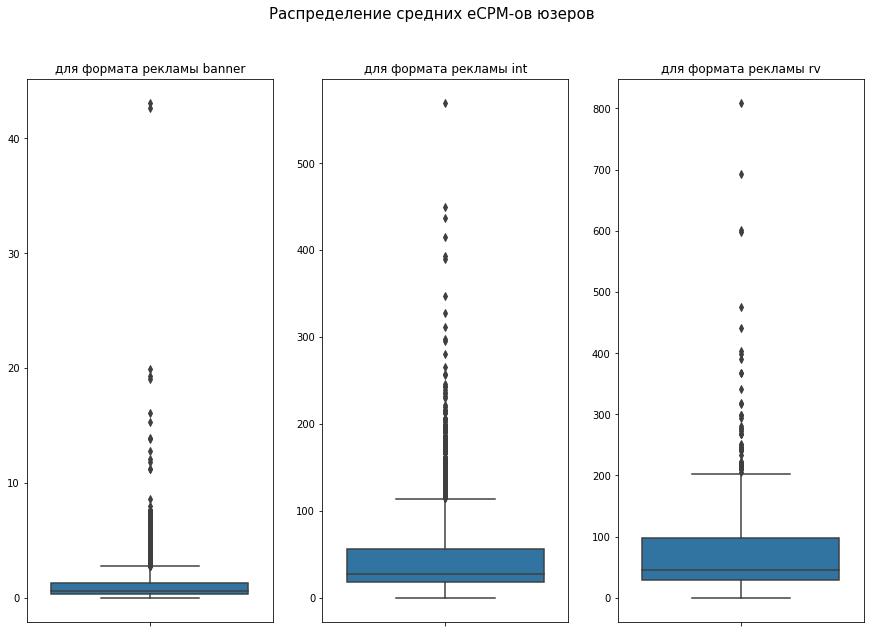

In [58]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
sns.boxplot(y = df.groupby(['ad_type', 'profile_id'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "banner"').eCPM).set(ylabel=None)
plt.title("для формата рекламы banner")

plt.subplot(1, 3, 2)
sns.boxplot(y = df.groupby(['ad_type', 'profile_id'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "int"').eCPM).set(ylabel=None)
plt.title("для формата рекламы int")

plt.subplot(1, 3, 3)
sns.boxplot(y = df.groupby(['ad_type', 'profile_id'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "rv"').eCPM).set(ylabel=None)
plt.title("для формата рекламы rv")

plt.suptitle("Распределение средних eCPM-ов юзеров", size = 15)
plt.show()

In [57]:
df.groupby(['ad_type', 'profile_id'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "banner"').describe()

,eCPM
count,3508.000000
mean,1.157111
std,1.867792
min,0.013930
25%,0.322804
50%,0.583002
75%,1.297329
max,43.021387


In [59]:
df.groupby(['ad_type', 'profile_id'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "int"').describe()

,eCPM
count,3962.000000
mean,45.557457
std,46.877344
min,0.000000
25%,17.620615
50%,27.623670
75%,56.397665
max,568.678270


In [60]:
df.groupby(['ad_type', 'profile_id'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "rv"').describe()

,eCPM
count,1324.000000
mean,80.502004
std,79.154906
min,0.223222
25%,28.240000
50%,46.019935
75%,98.067206
max,808.294820


В среднем от одного пользователя при просмотре баннерной рекламы поступающий доход находится в диапозоне от 0,32 до 1,3 долларов, при просмотре полноэкранной рекламы от 17,62 до 56,4 долларов и видео в диапозоне от 28,24 до 98,07 долларов.
Минимальный доход, полученный от баннерной рекламы 0,01 доллар, от полноэкранной - 0 долларов и от видео - 0,22 доллара. Медианные доходы от реклам: banner - 0.58 долларов, int - 27.62 доллара, rv - 46,02 доллара.

#  Распределение средних CPM-ов по городам для каждого формата рекламы

In [17]:
df[['ad_type', 'eCPM', 'city', 'os_version']]

,ad_type,eCPM,city,os_version
0,banner,0.510313,Norwalk,11
1,banner,0.510313,Norwalk,11
2,banner,2.386163,Charlotte,11
3,int,13.893784,Cocoa,10
4,banner,6.827570,NaN,10
...,...,...,...,...
860074,banner,0.019972,Elmira,12
860075,banner,6.740355,Cherry Hill,12
860076,banner,2.780058,Cherry Hill,12
860077,banner,2.780058,Cherry Hill,12


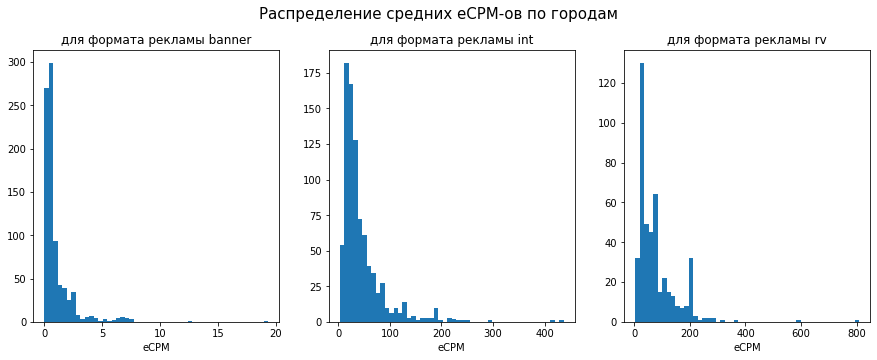

In [18]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.hist(df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}) \
  .query('ad_type == "banner"').eCPM, bins = 50)
plt.xlabel('eCPM')
plt.title("для формата рекламы banner")

plt.subplot(1, 3, 2)
plt.hist(df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}) \
  .query('ad_type == "int"').eCPM, bins = 50)
plt.xlabel('eCPM')
plt.title("для формата рекламы int")

plt.subplot(1, 3, 3)
plt.hist(df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}) \
  .query('ad_type == "rv"').eCPM, bins = 50)
plt.xlabel('eCPM')
plt.title("для формата рекламы rv")

plt.suptitle("Распределение средних eCPM-ов по городам", size = 15, y = 1)

plt.show()

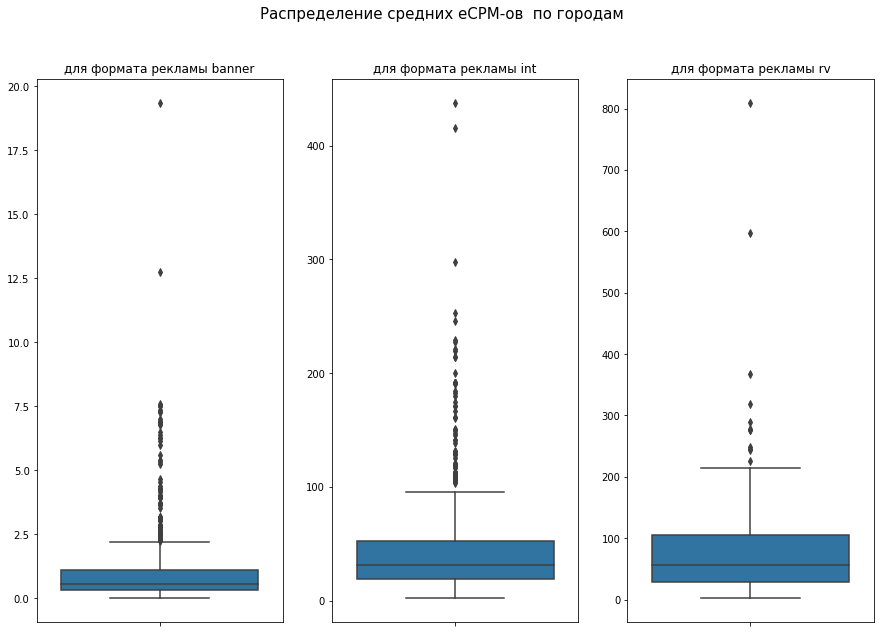

In [61]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
sns.boxplot(y = df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "banner"').eCPM).set(ylabel=None)
plt.title("для формата рекламы banner")

plt.subplot(1, 3, 2)
sns.boxplot(y = df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "int"').eCPM).set(ylabel=None)
plt.title("для формата рекламы int")

plt.subplot(1, 3, 3)
sns.boxplot(y = df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "rv"').eCPM).set(ylabel=None)
plt.title("для формата рекламы rv")

plt.suptitle("Распределение средних eCPM-ов  по городам", size = 15)
plt.show()

Можно заметить, что данные распределены ненормально, попробуем прологарифмировать значения для дальнейшего рассмотрения.

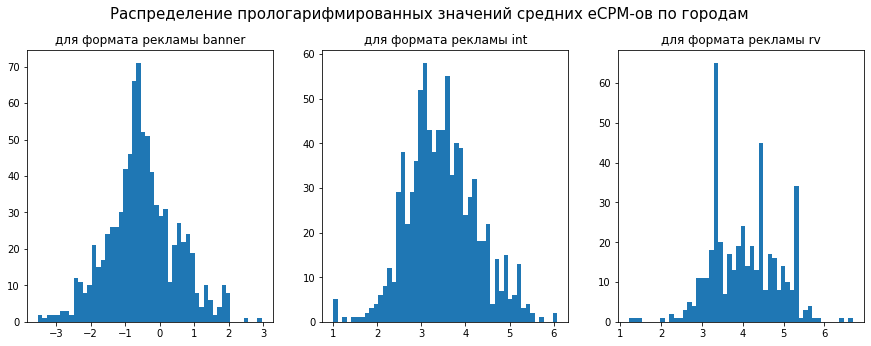

In [30]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.hist(np.log(df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type=="banner"').eCPM), bins = 50)
plt.title("для формата рекламы banner")
plt.subplot(1, 3, 2)
plt.hist(np.log(df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type=="int"').eCPM), bins = 50)
plt.title("для формата рекламы int")
plt.subplot(1, 3, 3)
plt.hist(np.log(df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type=="rv"').eCPM), bins = 50)
plt.title("для формата рекламы rv")
plt.suptitle("Распределение прологарифмированных значений средних eCPM-ов по городам ", size = 15, y = 1)
plt.show()

In [36]:
a = np.log(df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type=="banner"').eCPM)
b = np.log(df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type=="int"').eCPM)
c = np.log(df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type=="rv"').eCPM)

Посмотрим, распределены ли данные нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность делаем семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты. Для воспроизводимости результата использован параметр random_state=17 в методе sample.

In [40]:
scipy.stats.shapiro(a.sample(1000, random_state=17, replace=True))

ShapiroResult(statistic=0.9887214303016663, pvalue=5.909593028263771e-07)

In [41]:
scipy.stats.shapiro(b.sample(1000, random_state=17, replace=True))

ShapiroResult(statistic=0.9896131753921509, pvalue=1.6225206991293817e-06)

In [42]:
scipy.stats.shapiro(c.sample(1000, random_state=17, replace=True))

ShapiroResult(statistic=0.9794691205024719, pvalue=1.1334519434136325e-10)

Тест Шапиро_Уилка говорит нам о том, что данные распределены ненормально, возможно это связано с тем, что выборки большие. Посмотрим на результаты normaltest. Этот статтест специально создавался для проверки нормальности на больших выборках, и поэтому у него отсутствуют недостатки Шапиро-Уилка.

In [43]:
scipy.stats.normaltest(a)

NormaltestResult(statistic=5.219662534120454, pvalue=0.0735469525096538)

In [44]:
scipy.stats.normaltest(b)

NormaltestResult(statistic=9.757181696912905, pvalue=0.007607726917891117)

In [45]:
scipy.stats.normaltest(c)

NormaltestResult(statistic=0.3763545655520425, pvalue=0.8284678211377025)

normaltest показывает, что выборки пролагорифмированных значений для форматов рекламы banner и rv распределены нормально, в оличии от данных для формата int.

Логарифмирование выборок не помогло привести распределение к нормальному виду. Поэтому попробуем применить непараметрический тест - Критерий Крускала-Уоллиса на первоначальных данных. Он проверяет нулевую гипотезу о том, что медианы совокупности всех групп равны. Это непараметрическая версия ANOVA. 

In [49]:
d = df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "banner"').eCPM
e = df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "int"').eCPM
f = df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "rv"').eCPM

In [50]:
scipy.stats.kruskal(d, e, f)

KruskalResult(statistic=1602.7238945504341, pvalue=0.0)

Отклоняем нулевую гипотезу, медианные значения сравниваемых групп значительно различаются.

In [62]:
df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "banner"').describe()

,eCPM
count,856.000000
mean,1.026122
std,1.439121
min,0.029317
25%,0.342273
50%,0.568364
75%,1.088064
max,19.326435


In [63]:
df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "int"').describe()

,eCPM
count,869.000000
mean,44.829423
std,44.671766
min,2.750576
25%,19.411409
50%,31.001778
75%,52.142344
max,437.039882


In [64]:
df.groupby(['ad_type', 'city'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type == "rv"').describe()

,eCPM
count,454.000000
mean,80.532356
std,76.601650
min,3.339551
25%,28.240000
50%,55.959567
75%,104.940871
max,808.294820


Усредненный городской пользователь приносит eCPM от баннерной рекламы в диапазоне от 0,34 до 1,09 долларов, от полноэкранной рекламы - от 19,41 до 52,14 долларов, от видео - от 28,24 до 104,94 долларов. Минимальный полученный доход от banner - 0,03 доллара, от int - 2,75 долларов и от rv - 3,34 доллара. От рекламы вида - banner максимально было получено всего лишь 19,33 доллара, а от int и rv - 437,04 и 808,29 долларов соответственно.

# Cредние eCPM-ы по городам, версиям ОС

In [22]:
print(f'В данных {df["city"].nunique()} уникальных городов и {df["os_version"].nunique()} версий ОС')

В данных 920 уникальных городов и 11 версий ОС


### Рассмотрим средние eCPM-ы для каждого типа рекламы по городам:
#### Для горизонтального баннера

In [23]:
eCPM_city_banner = df.groupby(['city', 'ad_type'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type=="banner"')
eCPM_city_int = df.groupby(['city', 'ad_type'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type=="int"')
eCPM_city_rv = df.groupby(['city', 'ad_type'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type=="rv"')

In [24]:
eCPM_city_banner.sort_values('eCPM')
# средние eCPM-ы в диапазоне от 0.029317 до 19.326435
# округлим до одного знака после запятой для группировки городов по eCPM

,city,ad_type,eCPM
280,Canonsburg,banner,0.029317
46,Anderson,banner,0.030573
1173,Malden,banner,0.037929
2036,Vista,banner,0.040451
146,Bell Gardens,banner,0.040858
...,...,...,...
1072,Lawrenceville,banner,7.519341
1522,Oxnard,banner,7.519341
908,Huron,banner,7.574941
1339,Mountain View,banner,12.750000


In [25]:
eCPM_city_banner.eCPM = eCPM_city_banner.eCPM.round(1)

In [26]:
eCPM_city_banner

,city,ad_type,eCPM
0,Aberdeen,banner,0.3
3,Abilene,banner,0.9
6,Addison,banner,0.1
7,Afton,banner,0.3
9,Akron,banner,0.4
...,...,...,...
2165,Youngstown,banner,1.5
2168,Ypsilanti,banner,0.3
2171,Yukon,banner,0.1
2174,Yuma,banner,0.2


In [27]:
pd.set_option('display.max_colwidth', None)

In [28]:
eCPM_city_banner = eCPM_city_banner.groupby('eCPM', as_index=False).agg({'city': [set, 'count']}) \
.sort_values('eCPM', ascending=False).head(10)
# возьмем топ-10

In [29]:
eCPM_city_banner

eCPM                                                         city      
                                                                  set count
59  19.3                                                  {La Crosse}     1
58  12.8                                              {Mountain View}     1
57   7.6                                                      {Huron}     1
56   7.5                                      {Lawrenceville, Oxnard}     2
55   7.3                          {Corbin, Clarks Summit, Colchester}     3
54   7.0                                                     {Dobson}     1
53   6.9                                                     {Muncie}     1
52   6.8  {Powell, Post Falls, Gloucester City, Gardena, Orland Park}     5
51   6.5                                                   {Brockton}     1
50   6.4                                                   {Kennesaw}     1

In [30]:
eCPM_city_banner.columns = eCPM_city_banner.columns.map(''.join)
eCPM_city_banner = eCPM_city_banner.rename(columns=({'cityset': 'city', 'citycount': 'count_city'}))

In [31]:
eCPM_city_banner

,eCPM,city,count_city
59,19.3,{La Crosse},1
58,12.8,{Mountain View},1
57,7.6,{Huron},1
56,7.5,"{Lawrenceville, Oxnard}",2
55,7.3,"{Corbin, Clarks Summit, Colchester}",3
54,7.0,{Dobson},1
53,6.9,{Muncie},1
52,6.8,"{Powell, Post Falls, Gloucester City, Gardena, Orland Park}",5
51,6.5,{Brockton},1
50,6.4,{Kennesaw},1


In [32]:
eCPM_city_banner['city'] = eCPM_city_banner['city'].apply(lambda x: ', '.join(x))

In [33]:
eCPM_city_banner

,eCPM,city,count_city
59,19.3,La Crosse,1
58,12.8,Mountain View,1
57,7.6,Huron,1
56,7.5,"Lawrenceville, Oxnard",2
55,7.3,"Corbin, Clarks Summit, Colchester",3
54,7.0,Dobson,1
53,6.9,Muncie,1
52,6.8,"Powell, Post Falls, Gloucester City, Gardena, Orland Park",5
51,6.5,Brockton,1
50,6.4,Kennesaw,1


#### Для полноэкранной рекламы

In [34]:
eCPM_city_int.sort_values('eCPM')
# средние eCPM-ы в диапазоне от 2.750576 до 437.039882
# округлим до целого для группировки городов по eCPM

,city,ad_type,eCPM
1121,Lincoln City,int,2.750576
332,Chantilly,int,2.890648
975,Kailua-Kona,int,2.910271
1460,Ocala,int,2.926826
678,Fort Walton Beach,int,2.960040
...,...,...,...
1450,Norwood,int,245.528961
1369,Nashua,int,252.555569
1728,Rohnert Park,int,297.600000
1030,La Crosse,int,415.159332


In [35]:
eCPM_city_int.eCPM = eCPM_city_int.eCPM.round(0)

In [36]:
eCPM_city_int = eCPM_city_int.groupby('eCPM', as_index=False).agg({'city': [set, 'count']}) \
.sort_values('eCPM', ascending=False).head(10)
# возьмем топ-10

In [37]:
eCPM_city_int.columns = eCPM_city_int.columns.map(''.join)
eCPM_city_int = eCPM_city_int.rename(columns=({'cityset': 'city', 'citycount': 'count_city'}))

In [38]:
eCPM_city_int

,eCPM,city,count_city
135,437.0,{Madisonville},1
134,415.0,{La Crosse},1
133,298.0,{Rohnert Park},1
132,253.0,{Nashua},1
131,246.0,{Norwood},1
130,229.0,{Spirit Lake},1
129,227.0,{Rocky Mount},1
128,221.0,{Oxnard},1
127,219.0,{Lake Worth},1
126,214.0,"{Fredericksburg, East Peoria}",2


In [39]:
eCPM_city_int['city'] = eCPM_city_int['city'].apply(lambda x: ', '.join(x))

In [40]:
eCPM_city_int

,eCPM,city,count_city
135,437.0,Madisonville,1
134,415.0,La Crosse,1
133,298.0,Rohnert Park,1
132,253.0,Nashua,1
131,246.0,Norwood,1
130,229.0,Spirit Lake,1
129,227.0,Rocky Mount,1
128,221.0,Oxnard,1
127,219.0,Lake Worth,1
126,214.0,"Fredericksburg, East Peoria",2


#### Для видео

In [41]:
eCPM_city_rv.sort_values('eCPM')
# средние eCPM-ы в диапазоне от 3.339551 до 808.294820
# округлим до целого для группировки городов по eCPM

,city,ad_type,eCPM
2009,Utica,rv,3.339551
679,Fort Walton Beach,rv,4.074518
1456,Oak Creek,rv,4.178594
166,Bethlehem,rv,7.974126
2004,Uniontown,rv,9.083504
...,...,...,...
1725,Rocky Mount,rv,290.111970
2019,Valparaiso,rv,318.750000
918,Idaho Falls,rv,366.840286
1451,Norwood,rv,597.984497


In [42]:
eCPM_city_rv.eCPM = eCPM_city_rv.eCPM.round(0)

In [43]:
eCPM_city_rv = eCPM_city_rv.groupby('eCPM', as_index=False).agg({'city': [set, 'count']}) \
.sort_values('eCPM', ascending=False).head(10)
# возьмем топ-10

In [44]:
eCPM_city_rv.columns = eCPM_city_rv.columns.map(''.join)
eCPM_city_rv = eCPM_city_rv.rename(columns=({'cityset': 'city', 'citycount': 'count_city'}))

In [45]:
eCPM_city_rv

,eCPM,city,count_city
147,808.0,{East Peoria},1
146,598.0,{Norwood},1
145,367.0,{Idaho Falls},1
144,319.0,{Valparaiso},1
143,290.0,{Rocky Mount},1
142,279.0,{Hilliard},1
141,277.0,{Glen Burnie},1
140,276.0,{Mayfield},1
139,249.0,{El Paso},1
138,245.0,{Port Huron},1


In [46]:
eCPM_city_rv['city'] = eCPM_city_rv['city'].apply(lambda x: ', '.join(x))

In [47]:
eCPM_city_rv

,eCPM,city,count_city
147,808.0,East Peoria,1
146,598.0,Norwood,1
145,367.0,Idaho Falls,1
144,319.0,Valparaiso,1
143,290.0,Rocky Mount,1
142,279.0,Hilliard,1
141,277.0,Glen Burnie,1
140,276.0,Mayfield,1
139,249.0,El Paso,1
138,245.0,Port Huron,1


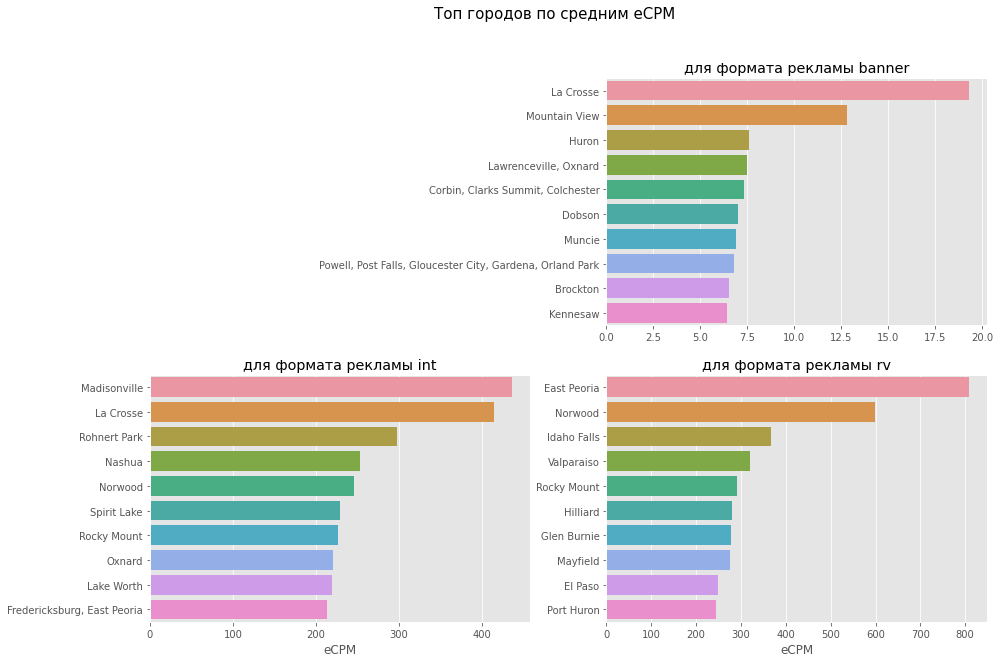

In [48]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 2)
sns.barplot(x='eCPM', y='city', data=eCPM_city_banner).set(ylabel=None, xlabel=None)
#plt.xticks(rotation=90)
plt.title("для формата рекламы banner")


plt.subplot(2, 2, 3)
sns.barplot(x='eCPM', y='city', data=eCPM_city_int).set(ylabel=None)
#plt.xticks(rotation=90)
plt.title("для формата рекламы int")

plt.subplot(2, 2, 4)
sns.barplot(x='eCPM', y='city', data=eCPM_city_rv).set(ylabel=None)
#plt.xticks(rotation=90)
plt.title("для формата рекламы rv")

plt.suptitle("Топ городов по средним eCPM", size = 15)

plt.show()

Видно, что топ городов различается для каждого вида рекламы. Можно выделить город La Crosse - в нем большие средние значения eCPM-ов для реклам banner и int, так же город Oxnard входит в топ по этим двум рекламам. У реклам int и rv больше совместных городов, которые входят в топ - Norwood, Spirit Lake, Rocky Mount и East Peoria.

### Рассмотрим средние eCPM-ы для каждого типа рекламы по версиям ос:

In [49]:
eCPM_os_version_banner = df.groupby(['os_version', 'ad_type'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type=="banner"')
eCPM_os_version_int = df.groupby(['os_version', 'ad_type'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type=="int"')
eCPM_os_version_rv = df.groupby(['os_version', 'ad_type'], as_index=False).agg({'eCPM': 'mean'}).query('ad_type=="rv"')

In [50]:
eCPM_os_version_banner.sort_values(by='os_version', key=natsort_keygen())

,os_version,ad_type,eCPM
9,5.0.2,banner,0.198288
12,6.0.1,banner,0.254481
15,7.0,banner,0.278132
18,7.1.1,banner,0.236141
21,7.1.2,banner,0.144868
23,8.0.0,banner,0.368201
26,8.1.0,banner,0.320697
29,9,banner,0.549553
0,10,banner,0.591274
3,11,banner,0.592766


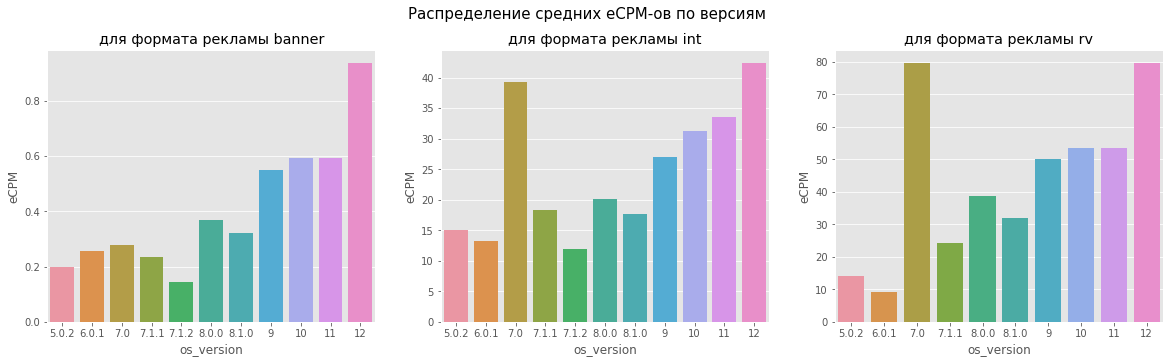

In [52]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
sns.barplot(x='os_version', y='eCPM', data=eCPM_os_version_banner.sort_values(by='os_version', key=natsort_keygen()))
#plt.ylabel('ecpm')
plt.title("для формата рекламы banner")


plt.subplot(1, 3, 2)
sns.barplot(x='os_version', y='eCPM', data=eCPM_os_version_int.sort_values(by='os_version', key=natsort_keygen()))
#plt.ylabel('ecpm_int')
plt.title("для формата рекламы int")

plt.subplot(1, 3, 3)
sns.barplot(x='os_version', y='eCPM', data=eCPM_os_version_rv.sort_values(by='os_version', key=natsort_keygen()))
#plt.ylabel('ecpm_rv')
plt.title("для формата рекламы rv")

plt.suptitle("Распределение средних eCPM-ов по версиям", size = 15, y = 1)

plt.show()

Пользователи с версией 7.1.2 не смотрят видео, возможно такой формат рекламы отсутствует в данной версии. Наиболее доходнымим форматами рекламы являются int (полноэкранная реклама) и rv (видео), они принесли больше дохода на версиях 7.0 и 12. Заметно увеличение среднего eCPM от версии к версии за исключением трех версий ОС - 7.1.1, 7.1.2, 8.1.0, так же в форматах рекламы int и rv исключение составляет версия 6.0.1.

Для более детального рассмотрения значений eCPM можно взглянуть на таблицу:

In [51]:
eCPM_os_version = df.groupby(['ad_type', 'os_version'], as_index=False) \
    .agg({'eCPM': 'mean'}) \
    .pivot_table(columns='os_version', index='ad_type', values='eCPM') \
    .sort_values(by='os_version', key=natsort_keygen(), axis=1)

In [53]:
eCPM_os_version

os_version,5.0.2,6.0.1,7.0,7.1.1,7.1.2,8.0.0,8.1.0,9,10,11,12
ad_type,,,,,,,,,,,
banner,0.198288,0.254481,0.278132,0.236141,0.144868,0.368201,0.320697,0.549553,0.591274,0.592766,0.936871
int,14.969333,13.172003,39.266162,18.232767,11.964031,20.030134,17.694561,27.004733,31.216643,33.468471,42.391070
rv,14.188713,9.191038,79.662468,24.215299,NaN,38.614653,31.830249,50.151552,53.336882,53.378872,79.568911


#  Распределение доходов по городам и версиям ОС для каждого формата рекламы

In [54]:
df[['ad_type', 'revenue', 'city', 'os_version']]

,ad_type,revenue,city,os_version
0,banner,0.000510,Norwalk,11
1,banner,0.000510,Norwalk,11
2,banner,0.002386,Charlotte,11
3,int,0.013894,Cocoa,10
4,banner,0.006828,NaN,10
...,...,...,...,...
860074,banner,0.000020,Elmira,12
860075,banner,0.006740,Cherry Hill,12
860076,banner,0.002780,Cherry Hill,12
860077,banner,0.002780,Cherry Hill,12


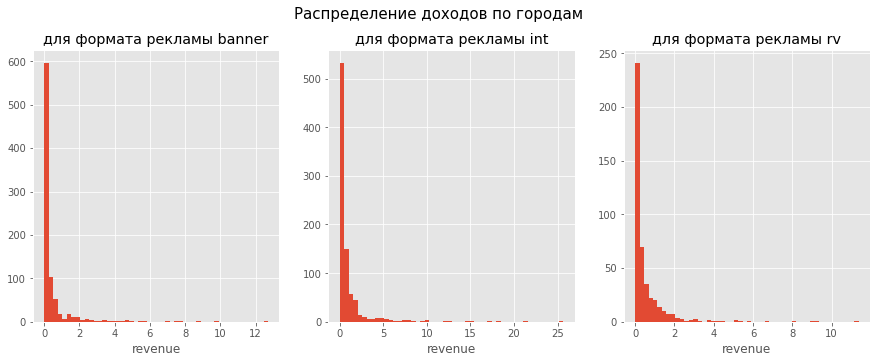

In [73]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.hist(df.groupby(['ad_type', 'city'], as_index=False).agg({'revenue': 'sum'}) \
  .query('ad_type == "banner"').revenue, bins = 50)
plt.xlabel('revenue')
plt.title("для формата рекламы banner")

plt.subplot(1, 3, 2)
plt.hist(df.groupby(['ad_type', 'city'], as_index=False).agg({'revenue': 'sum'}) \
  .query('ad_type == "int"').revenue, bins = 50)
plt.xlabel('revenue')
plt.title("для формата рекламы int")

plt.subplot(1, 3, 3)
plt.hist(df.groupby(['ad_type', 'city'], as_index=False).agg({'revenue': 'sum'}) \
  .query('ad_type == "rv"').revenue, bins = 50)
plt.xlabel('revenue')
plt.title("для формата рекламы rv")

plt.suptitle("Распределение доходов по городам", size = 15, y = 1)

plt.show()

In [68]:
revenue_city_banner = df.groupby(['city', 'ad_type'], as_index=False).agg({'revenue': 'sum'}).query('ad_type=="banner"')
revenue_city_int = df.groupby(['city', 'ad_type'], as_index=False).agg({'revenue': 'sum'}).query('ad_type=="int"')
revenue_city_rv = df.groupby(['city', 'ad_type'], as_index=False).agg({'revenue': 'sum'}).query('ad_type=="rv"')

In [74]:
revenue_city_banner.sort_values('revenue')
# revenue в диапазоне от 0.000031 до 12.708617
# округлим до одного знака после запятой для группировки городов по revenue

,city,ad_type,revenue
46,Anderson,banner,0.000031
2076,Waukesha,banner,0.000045
640,Federal Way,banner,0.000055
831,Hartford,banner,0.000085
1912,Strongsville,banner,0.000086
...,...,...,...
1289,Minneapolis,banner,7.629354
893,Houston,banner,8.664916
1886,Spokane,banner,8.862484
922,Indianapolis,banner,9.789215


In [75]:
revenue_city_banner.revenue = revenue_city_banner.revenue.round(1)

In [76]:
revenue_city_banner = revenue_city_banner.groupby('revenue', as_index=False).agg({'city': [set, 'count']}) \
.sort_values('revenue', ascending=False).head(10)
# возьмем топ-10

In [78]:
revenue_city_banner.columns = revenue_city_banner.columns.map(''.join)
revenue_city_banner = revenue_city_banner.rename(columns=({'cityset': 'city', 'citycount': 'count_city'}))
revenue_city_banner['city'] = revenue_city_banner['city'].apply(lambda x: ', '.join(x))

In [79]:
revenue_city_banner

,revenue,city,count_city
44,12.7,New York,1
43,9.8,Indianapolis,1
42,8.9,Spokane,1
41,8.7,Houston,1
40,7.6,"Cleveland, Minneapolis",2
39,6.9,Charlotte,1
38,5.8,Gardena,1
37,5.6,"Kansas City, Dallas",2
36,4.9,Springfield,1
35,4.6,"Tampa, Chicago, Columbus",3


In [81]:
revenue_city_int.sort_values('revenue')
# revenue в диапазоне от 0.002891 до 25.674272
# округлим до одного знака после запятой для группировки городов по revenue

,city,ad_type,revenue
332,Chantilly,int,0.002891
1460,Ocala,int,0.002927
641,Federal Way,int,0.005540
944,Jacksonville Beach,int,0.007987
872,Hoffman Estates,int,0.008474
...,...,...,...
337,Charlotte,int,14.940739
1290,Minneapolis,int,17.286339
390,Cleveland,int,18.112861
923,Indianapolis,int,21.534431


In [82]:
revenue_city_int.revenue = revenue_city_int.revenue.round(1)
revenue_city_int = revenue_city_int.groupby('revenue', as_index=False).agg({'city': [set, 'count']}) \
.sort_values('revenue', ascending=False).head(10)
# возьмем топ-10
revenue_city_int.columns = revenue_city_int.columns.map(''.join)
revenue_city_int = revenue_city_int.rename(columns=({'cityset': 'city', 'citycount': 'count_city'}))
revenue_city_int['city'] = revenue_city_int['city'].apply(lambda x: ', '.join(x))

In [83]:
revenue_city_int

,revenue,city,count_city
75,25.7,New York,1
74,21.5,Indianapolis,1
73,18.1,Cleveland,1
72,17.3,Minneapolis,1
71,14.9,Charlotte,1
70,14.5,Houston,1
69,12.4,Columbus,1
68,12.2,Los Angeles,1
67,10.2,Dallas,1
66,10.1,"Denver, Cincinnati",2


In [85]:
revenue_city_rv.sort_values('revenue')
# revenue в диапазоне от 0.004075 до 11.389241
# округлим до одного знака после запятой для группировки городов по revenue

,city,ad_type,revenue
679,Fort Walton Beach,rv,0.004075
2009,Utica,rv,0.006679
2004,Uniontown,rv,0.009084
1645,Prescott Valley,rv,0.010761
400,Coeur d'Alene,rv,0.011530
...,...,...,...
391,Cleveland,rv,6.797868
1473,Oklahoma City,rv,8.045251
1400,New York,rv,9.071508
1291,Minneapolis,rv,9.319597


In [86]:
revenue_city_rv.revenue = revenue_city_rv.revenue.round(1)
revenue_city_rv = revenue_city_rv.groupby('revenue', as_index=False).agg({'city': [set, 'count']}) \
.sort_values('revenue', ascending=False).head(10)
# возьмем топ-10
revenue_city_rv.columns = revenue_city_rv.columns.map(''.join)
revenue_city_rv = revenue_city_rv.rename(columns=({'cityset': 'city', 'citycount': 'count_city'}))
revenue_city_rv['city'] = revenue_city_rv['city'].apply(lambda x: ', '.join(x))

In [87]:
revenue_city_rv

,revenue,city,count_city
40,11.4,Houston,1
39,9.3,Minneapolis,1
38,9.1,New York,1
37,8.0,Oklahoma City,1
36,6.8,Cleveland,1
35,5.8,Rocky Mount,1
34,5.4,Indianapolis,1
33,5.2,"Rockford, Columbus",2
32,4.5,Cincinnati,1
31,4.2,Lee's Summit,1


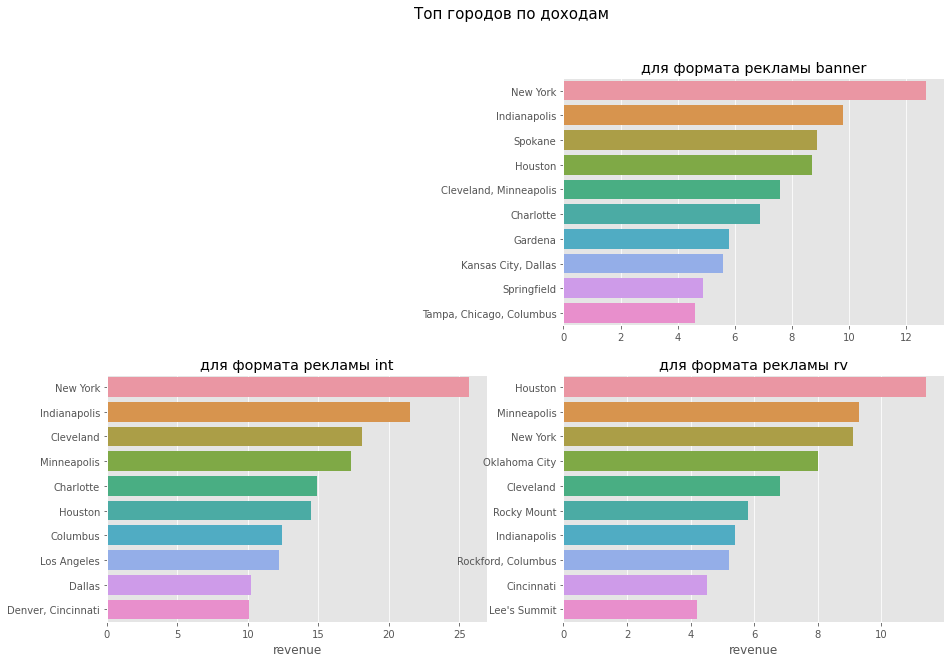

In [88]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 2)
sns.barplot(x='revenue', y='city', data=revenue_city_banner).set(ylabel=None, xlabel=None)
plt.title("для формата рекламы banner")


plt.subplot(2, 2, 3)
sns.barplot(x='revenue', y='city', data=revenue_city_int).set(ylabel=None)
plt.title("для формата рекламы int")

plt.subplot(2, 2, 4)
sns.barplot(x='revenue', y='city', data=revenue_city_rv).set(ylabel=None)
plt.title("для формата рекламы rv")

plt.suptitle("Топ городов по доходам", size = 15)

plt.show()

В данном случае самыми доходными городами для всех видов рекламы являются New York, Indianapolis, Houston, Cleveland, Minneapolis, Columbus. Посмотрим топ городов по численности пользователей:

In [94]:
df.groupby('city', as_index=False).agg({'profile_id': 'count'}).sort_values('profile_id', ascending=False).head(10)

,city,profile_id
585,New York,17584
540,Minneapolis,12980
377,Houston,10137
796,Springfield,10135
140,Charlotte,9750
147,Chicago,8697
745,San Antonio,7912
388,Indianapolis,7126
413,Kansas City,7038
301,Gallatin,6573


Видно, что есть взаимосвязь между количеством пользователей в городах и полученным доходом от рекламы, за исключением двух городов - San Antonio и Gallatin. Они не входят в топ городов по прибыли ни от одного вида рекламы.

In [89]:
revenue_os_version_banner = df.groupby(['os_version', 'ad_type'], as_index=False).agg({'revenue': 'sum'}).query('ad_type=="banner"')
revenue_os_version_int = df.groupby(['os_version', 'ad_type'], as_index=False).agg({'revenue': 'sum'}).query('ad_type=="int"')
revenue_os_version_rv = df.groupby(['os_version', 'ad_type'], as_index=False).agg({'revenue': 'sum'}).query('ad_type=="rv"')

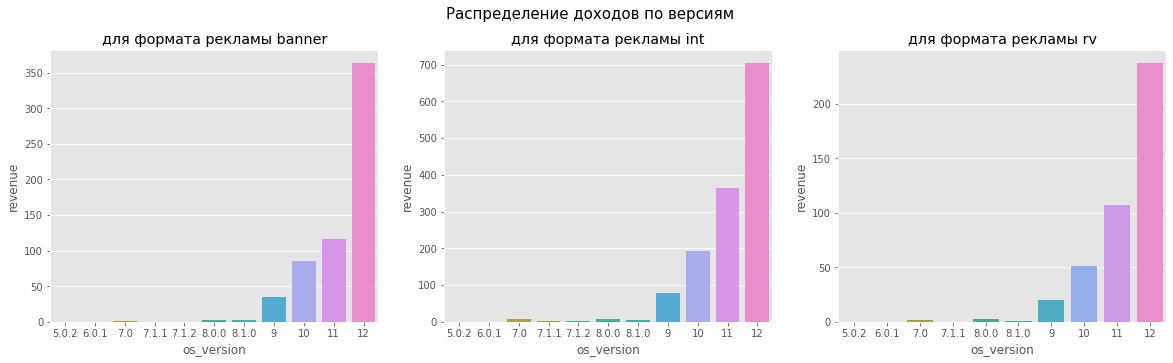

In [90]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
sns.barplot(x='os_version', y='revenue', data=revenue_os_version_banner.sort_values(by='os_version', key=natsort_keygen()))
plt.title("для формата рекламы banner")


plt.subplot(1, 3, 2)
sns.barplot(x='os_version', y='revenue', data=revenue_os_version_int.sort_values(by='os_version', key=natsort_keygen()))
plt.title("для формата рекламы int")

plt.subplot(1, 3, 3)
sns.barplot(x='os_version', y='revenue', data=revenue_os_version_rv.sort_values(by='os_version', key=natsort_keygen()))
plt.title("для формата рекламы rv")

plt.suptitle("Распределение доходов по версиям", size = 15, y = 1)

plt.show()

Можно заметить, что чем новее версия ОС у пользователя, тем больше доход мы получим, возможно это связано с тем, чтот людей со старыми версиями ОС просто меньше. Проверим это предположение:

In [88]:
df['os_version'].value_counts(normalize=True)

12       0.473895
11       0.243083
10       0.175415
9        0.077507
8.1.0    0.010754
8.0.0    0.009320
7.0      0.004717
7.1.2    0.002106
7.1.1    0.001560
5.0.2    0.000824
6.0.1    0.000819
Name: os_version, dtype: float64

Действительно, почти у половины пользователей 12 версия ОС, далее идут версии 11, 10, 9 и т.д.

Можно более детально посмотреть на доходы в таблице:

In [91]:
revenue_os_version = df.groupby(['ad_type', 'os_version'], as_index=False) \
    .agg({'revenue': 'sum'}) \
    .pivot_table(columns='os_version', index='ad_type', values='revenue') \
    .sort_values(by='os_version', key=natsort_keygen(), axis=1)

In [92]:
revenue_os_version

os_version,5.0.2,6.0.1,7.0,7.1.1,7.1.2,8.0.0,8.1.0,9,10,11,12
ad_type,,,,,,,,,,,
banner,0.135827,0.166939,1.065803,0.300135,0.252216,2.804952,2.847789,34.820249,85.002788,116.298348,363.488994
int,0.329325,0.579568,7.813966,1.203363,0.837482,6.770185,6.016151,78.475755,191.795052,363.634932,704.497187
rv,0.028377,0.036764,2.071224,0.121076,NaN,2.316879,0.923077,19.809863,51.470091,107.291533,237.592767


# Какой процент доходов содержит информацию о городе юзера 

In [96]:
df_revenue_city = df[['revenue', 'city']]

In [97]:
df_revenue_city.head()

,revenue,city
0,0.000510,Norwalk
1,0.000510,Norwalk
2,0.002386,Charlotte
3,0.013894,Cocoa
4,0.006828,NaN


In [98]:
print(f'В данных {round(df_revenue_city["city"].count() * 100 / df_revenue_city["revenue"].count(), 2)}% юзеров содержат информацию о городе')

В данных 62.36% юзеров содержат информацию о городе


# Зависимость eCPM от времени дня

In [100]:
df[['event_datetime', 'eCPM']]

,event_datetime,eCPM
0,2022-02-04 20:02:28,0.510313
1,2022-02-04 20:02:45,0.510313
2,2022-02-05 17:53:05,2.386163
3,2022-02-06 17:09:01,13.893784
4,2022-02-06 17:15:38,6.827570
...,...,...
860074,2022-02-03 08:29:27,0.019972
860075,2022-02-03 02:12:51,6.740355
860076,2022-02-03 02:13:06,2.780058
860077,2022-02-03 02:13:17,2.780058


In [83]:
df['event_datetime'] = df['event_datetime'].astype('datetime64[ns]')

In [84]:
df['hour'] = df['event_datetime'].dt.hour

In [85]:
df.groupby('hour', as_index=False).agg({'eCPM': 'sum'})

,hour,eCPM
0,0,117705.904481
1,1,128034.735195
2,2,131879.539167
3,3,149982.929456
4,4,153757.931711
5,5,181512.266823
6,6,166879.606086
7,7,143969.092958
8,8,118754.133004
9,9,93507.347865


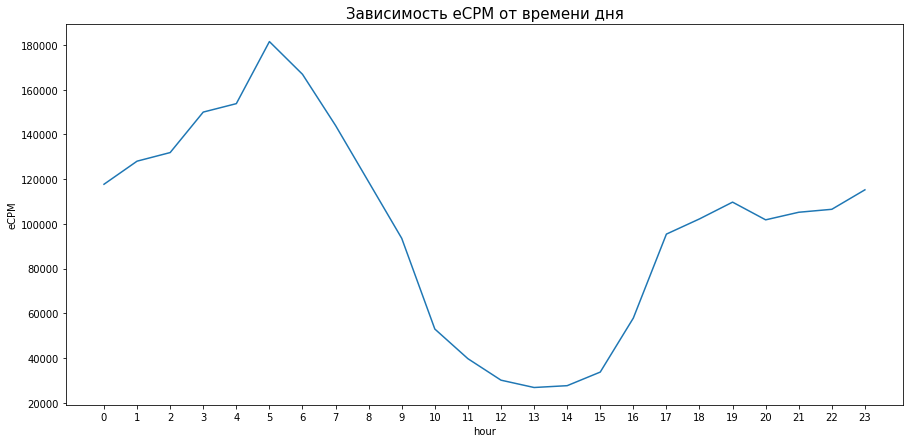

In [86]:
plt.figure(figsize=(15,7))
sns.lineplot(data=df.groupby('hour', as_index=False).agg({'eCPM': 'sum'}), x="hour", y="eCPM").set_xticks(range(24))
plt.title("Зависимость eCPM от времени дня", size = 15, y = 1)
plt.show()

По данному графику можно сделать вывод, что в ночное время eCPM увеличивается, достигая своего максимума в пять утра. Потом идет на спад до обеденного времени, и после трех часов дня начинается резкий скачок вверх.